Part A: IMDb Movie Review Sentiment Analysis

In [ ]:
!pip install -q wordcloud
!pip install -q tensorflow
import os
import re
import string
import joblib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

sns.set(style='whitegrid')
RANDOM_STATE = 42

In [ ]:
df=pd.read_excel('Imdb.xlsx')
print("Shape:", df.shape)
df.head()

Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Exploratory Data Analysis (EDA)

We will Check columns, missing values, class balance, and a few distribution plots.


Columns: ['review', 'sentiment']

Missing values per column:
 review       0
sentiment    0
dtype: int64

Sentiment value counts:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


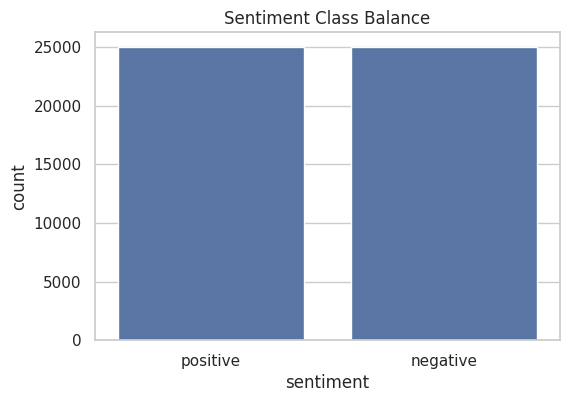

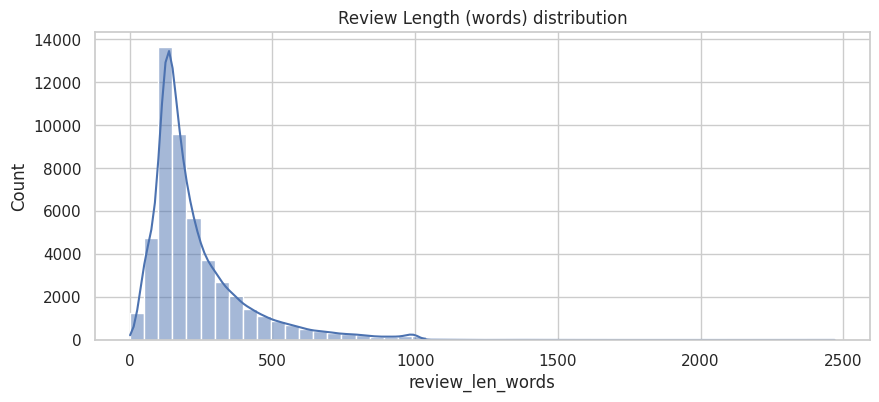

In [ ]:
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())

if 'review' not in df.columns:

    for c in df.columns:
        if 'review' in c.lower():
            df = df.rename(columns={c: 'review'})
if 'sentiment' not in df.columns:
    for c in df.columns:
        if 'sentiment' in c.lower():
            df = df.rename(columns={c: 'sentiment'})

df = df.dropna(subset=['review', 'sentiment']).reset_index(drop=True)

print("\nSentiment value counts:\n", df['sentiment'].value_counts())

df['review_len_chars'] = df['review'].str.len()
df['review_len_words'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Class Balance')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['review_len_words'], bins=50, kde=True)
plt.title('Review Length (words) distribution')
plt.show()

## Text cleaning & preprocessing
We'll:
- lowercase text
- remove HTML tags
- remove non-alphanumeric characters
- tokenize → remove stopwords → lemmatize
- reconstruct cleaned text column used for vectorization


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text_raw(text):
    """Light normalization: remove HTML, lowercase, remove excess whitespace."""
    text = str(text)

    text = re.sub(r'<[^>]+>', ' ', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()

def tokenize_and_lemmatize(text, remove_stopwords=True):
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', ' url ', text)
    text = re.sub(r'\S+@\S+', ' email ', text)

    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

print(tokenize_and_lemmatize)

<function tokenize_and_lemmatize at 0x7c77bfcbfce0>


In [ ]:
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
df['text_raw'] = df['review'].apply(clean_text_raw)
df['cleaned'] = df['text_raw'].apply(lambda x: " ".join(tokenize_and_lemmatize(x)))
df[['review', 'cleaned']].head(3)

,review,cleaned
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...


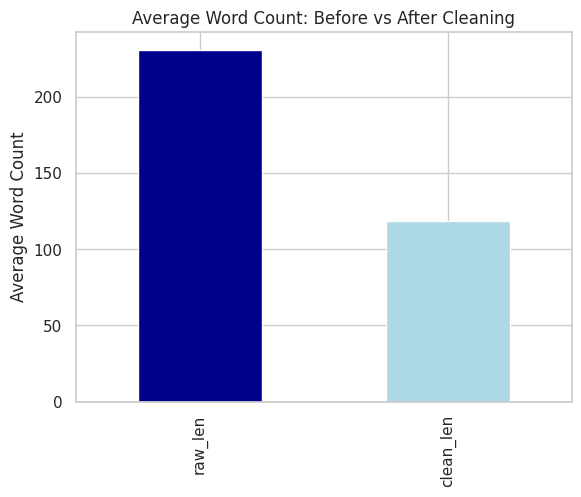

In [ ]:
df['raw_len'] = df['review'].apply(lambda x: len(str(x).split()))
df['clean_len'] = df['cleaned'].apply(lambda x: len(str(x).split()))
len_summary = df[['raw_len','clean_len']].mean()
len_summary.plot(kind='bar', color=['darkblue','lightblue'])
plt.title('Average Word Count: Before vs After Cleaning')
plt.ylabel('Average Word Count')
plt.show()

## Feature engineering
- Compute simple textual statistics (word count, char count, avg word length).
- Create TF-IDF features for modeling.
- We'll keep TF-IDF vectorizer inside a scikit-learn pipeline so everything is repeatable.


In [ ]:
df['word_count'] = df['cleaned'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned'].apply(len)
df['avg_word_len'] = df['char_count'] / (df['word_count'] + 1e-6)

df[['word_count','char_count','avg_word_len']].describe()

,word_count,char_count,avg_word_len
count,50000.000000,50000.000000,50000.000000
mean,118.830780,804.029300,6.712578
std,89.980263,623.699933,0.413037
min,1.000000,5.000000,4.928571
25%,63.000000,419.000000,6.439394
50%,88.000000,590.000000,6.709302
75%,144.000000,977.000000,6.978947
max,1407.000000,9082.000000,17.352941


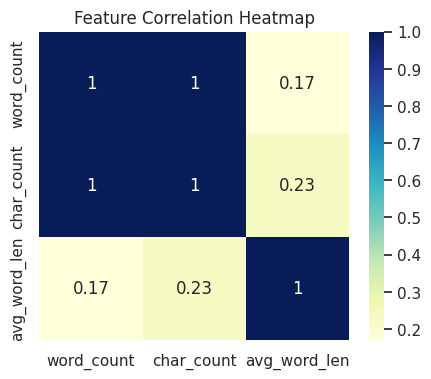

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(df[['word_count','char_count','avg_word_len']].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')
plt.show()

## Prepare data for modeling
- Convert labels to binary (positive -> 1, negative -> 0).
- Use stratified split to preserve class distribution.


In [ ]:
label_map = {'positive':1, 'negative':0}
def map_label(x):
    if str(x).lower() in label_map:
        return label_map[str(x).lower()]
    try:
        return int(x)
    except:
        return np.nan

y = df['sentiment'].apply(lambda x: map_label(x))
if y.isna().any():
    unique_vals = df['sentiment'].unique().tolist()
    print("Unmapped labels found. Unique labels:", unique_vals)

    top = df['sentiment'].value_counts().idxmax()
    y = df['sentiment'].apply(lambda x: 1 if x==top else 0)

X = df['cleaned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (40000,) Test: (10000,)


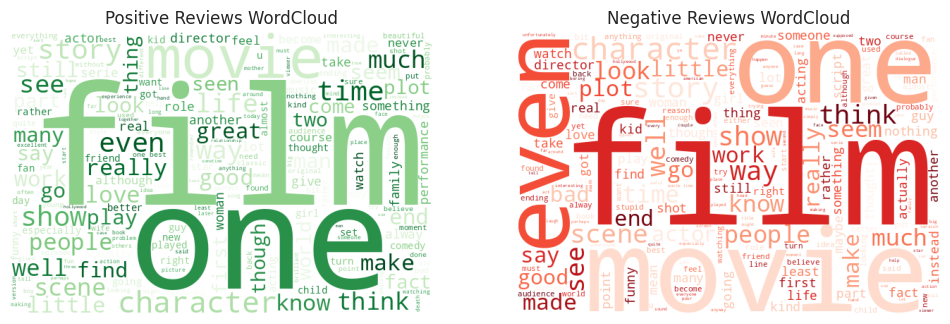

In [ ]:
from wordcloud import WordCloud, STOPWORDS
positive_text = ' '.join(df[df['sentiment'].str.lower()=='positive']['cleaned'])
negative_text = ' '.join(df[df['sentiment'].str.lower()=='negative']['cleaned'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white', colormap='Greens', stopwords=STOPWORDS).generate(positive_text))
plt.axis('off'); plt.title('Positive Reviews WordCloud')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white', colormap='Reds', stopwords=STOPWORDS).generate(negative_text))
plt.axis('off'); plt.title('Negative Reviews WordCloud')
plt.show()

## Modeling pipeline & baseline models
We'll create a TF-IDF → classifier pipeline and evaluate:
- Logistic Regression
- Multinomial Naive Bayes
- Linear SVM
- Random Forest (on TF-IDF features)


In [ ]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
models = {
    "LogisticRegression": Pipeline([('tfidf', tfidf),
                                    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    "MultinomialNB": Pipeline([('tfidf', tfidf),
                               ('clf', MultinomialNB())]),
    "LinearSVM": Pipeline([('tfidf', tfidf),
                           ('clf', LinearSVC(max_iter=2000, random_state=RANDOM_STATE))]),
    "RandomForest": Pipeline([('tfidf', tfidf),
                              ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))])
}
def train_and_evaluate(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return {"model": pipeline, "preds": preds, "acc": acc, "prec": prec, "rec": rec, "f1": f1}

results = []
for name, pipe in models.items():
    print(f"Training {name} ...")
    res = train_and_evaluate(pipe, X_train, y_train, X_test, y_test)
    res['name'] = name
    results.append(res)
    print(f"{name} done — Acc: {res['acc']:.4f}, F1: {res['f1']:.4f}")

Training LogisticRegression ...
LogisticRegression done — Acc: 0.8965, F1: 0.8974
Training MultinomialNB ...
MultinomialNB done — Acc: 0.8670, F1: 0.8694
Training LinearSVM ...
LinearSVM done — Acc: 0.8924, F1: 0.8932
Training RandomForest ...
RandomForest done — Acc: 0.8623, F1: 0.8620


In [ ]:
metrics_df = pd.DataFrame([{
    "Model": r['name'],
    "Accuracy": r['acc'],
    "Precision": r['prec'],
    "Recall": r['rec'],
    "F1-Score": r['f1']
} for r in results]).sort_values('F1-Score', ascending=False).reset_index(drop=True)
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,LogisticRegression,0.8965,0.889413,0.9056,0.897433
1,LinearSVM,0.8924,0.886830,0.8996,0.893169
2,MultinomialNB,0.8670,0.853837,0.8856,0.869429
3,RandomForest,0.8623,0.863828,0.8602,0.862010


## Neural Network Experiments: LSTM & Transformer (DistilBERT)


In [ ]:
MAX_VOCAB = 10000
MAX_LEN = 200
EMBED_DIM = 100
BATCH_SIZE = 32
EPOCHS = 4
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

model_lstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history = model_lstm.fit(X_train_pad, y_train, validation_split=0.1,
                         epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])

loss, acc = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test accuracy: {acc:.4f}")

y_pred_prob = model_lstm.predict(X_test_pad).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 220s 192ms/step - accuracy: 0.6861 - loss: 0.5587 - val_accuracy: 0.8790 - val_loss: 0.3067
Epoch 2/4
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 260s 190ms/step - accuracy: 0.9007 - loss: 0.2632 - val_accuracy: 0.8838 - val_loss: 0.2912
Epoch 3/4
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 219s 194ms/step - accuracy: 0.9300 - loss: 0.1939 - val_accuracy: 0.8802 - val_loss: 0.2922
Epoch 4/4
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 262s 194ms/step - accuracy: 0.9492 - loss: 0.1471 - val_accuracy: 0.8845 - val_loss: 0.3434
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
LSTM Test accuracy: 0.8865
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step
              precision    recall  f1-score   support

           0     0.9056    0.8630    0.8838      5000
           1     0.8691    0.9100    0.8891      5000

    accuracy                         0.8865     10000
   macro avg     0.8874    0.8865    0.8864     10000
weighted avg     0.8874    0.8865    0.8864

In [ ]:
from transformers import TFAutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"

model_tf = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    from_pt=True,
    use_safetensors=False
)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [ ]:
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 16
EPOCHS = 2
MAX_LEN = 200

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

train_encodings = tokenize_texts(X_train)
test_encodings  = tokenize_texts(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(y_train.values, dtype=tf.int32)
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(y_test.values, dtype=tf.int32)
)).batch(BATCH_SIZE)

## Model Evaluation (Confusion matrices and visualization)
Plot confusion matrices for the top 2 models by F1-score and a comparison bar chart.


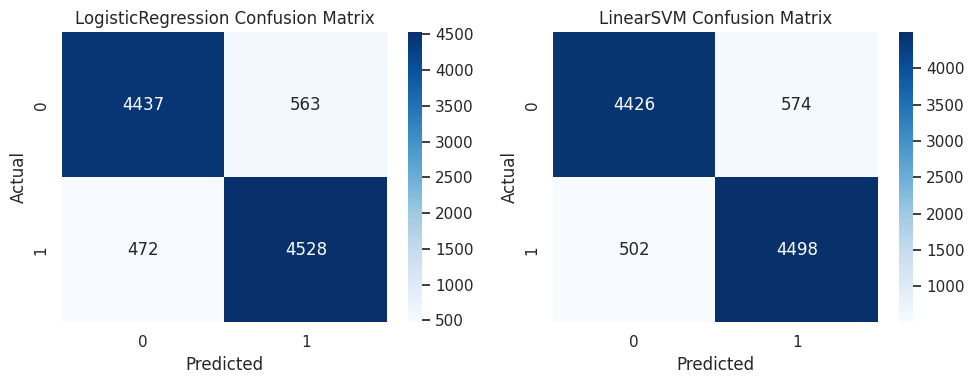

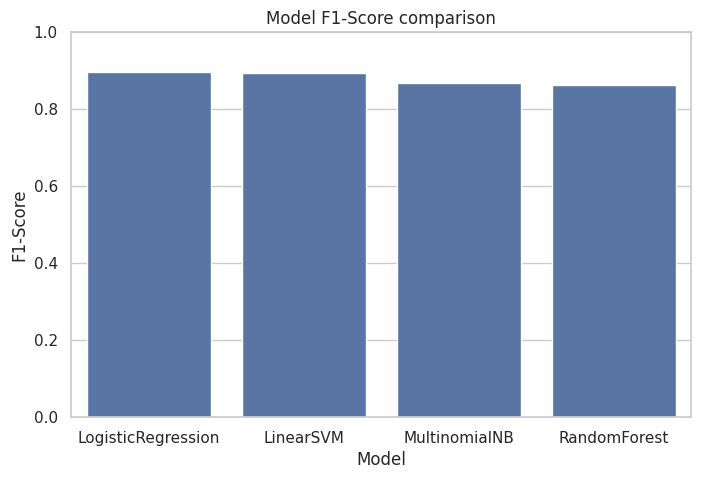

In [ ]:
top2 = metrics_df['Model'].tolist()[:2]
plt.figure(figsize=(10,4))
for i, model_name in enumerate(top2, 1):
    model_pipeline = next(r['model'] for r in results if r['name']==model_name)
    preds = model_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.subplot(1,2,i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="F1-Score", data=metrics_df)
plt.title("Model F1-Score comparison")
plt.ylim(0,1)
plt.show()

## Short hyperparameter tuning (example)
We'll run a light GridSearchCV on the best model (say Logistic Regression) to improve slightly. Use small grid for speed.


In [ ]:
best_model_name = metrics_df.loc[0, 'Model']
print("Top model:", best_model_name)

if best_model_name == "LogisticRegression":
    base_pipeline = models['LogisticRegression']
else:
    base_pipeline = models['LogisticRegression']

param_grid = {
    'tfidf__max_features': [5000, 8000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(base_pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_pipe = grid.best_estimator_
y_pred_best = best_pipe.predict(X_test)
print("Tuned model F1:", f1_score(y_test, y_pred_best))

Top model: LogisticRegression
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 2.0, 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 2)}
Tuned model F1: 0.8963402571711178


## Detailed classification report (for the tuned model)


In [ ]:
print(classification_report(y_test, y_pred_best, digits=4))
output_dir = Path("model_output")
output_dir.mkdir(exist_ok=True)
joblib.dump(best_pipe, output_dir / "sentiment_pipe_joblib.pkl")
print("Saved tuned pipeline to:", output_dir/"sentiment_pipe_joblib.pkl")

              precision    recall  f1-score   support

           0     0.9041    0.8842    0.8940      5000
           1     0.8867    0.9062    0.8963      5000

    accuracy                         0.8952     10000
   macro avg     0.8954    0.8952    0.8952     10000
weighted avg     0.8954    0.8952    0.8952     10000

Saved tuned pipeline to: model_output/sentiment_pipe_joblib.pkl


## Additional analysis & insights
- Which words/ngrams are most indicative of positive/negative? (explain how you'd inspect coefficients for linear models)
- Suggest improvements: use pretrained transformer embeddings (BERT) or data augmentation for more robust performance.
- Mention deployment: Flask or FastAPI + saved pipeline loaded via `joblib.load()` for a simple web demo.


In [ ]:
try:
    clf = best_pipe.named_steps['clf']
    vect = best_pipe.named_steps['tfidf']
    if hasattr(clf, 'coef_'):
        feature_names = vect.get_feature_names_out()
        coefs = clf.coef_[0]
        top_pos_idx = np.argsort(coefs)[-20:][::-1]
        top_neg_idx = np.argsort(coefs)[:20]
        print("Top positive features:", feature_names[top_pos_idx][:20])
        print("Top negative features:", feature_names[top_neg_idx][:20])
    else:
        print("Best classifier has no coef_ attribute (can't show linear features).")
except Exception as e:
    print("Could not extract features:", e)

Top positive features: ['excellent' 'great' 'perfect' 'amazing' 'hilarious' 'wonderful'
 'must see' 'one best' 'enjoyable' 'loved' 'brilliant' 'superb' 'favorite'
 'best' '10 10' 'today' 'well worth' 'enjoyed' 'funniest' 'fun']
Top negative features: ['worst' 'awful' 'waste' 'bad' 'boring' 'poorly' 'poor' 'terrible' 'fails'
 'horrible' 'dull' 'disappointing' 'disappointment' 'worse' 'nothing'
 'unfortunately' 'annoying' 'ridiculous' 'lame' 'avoid']


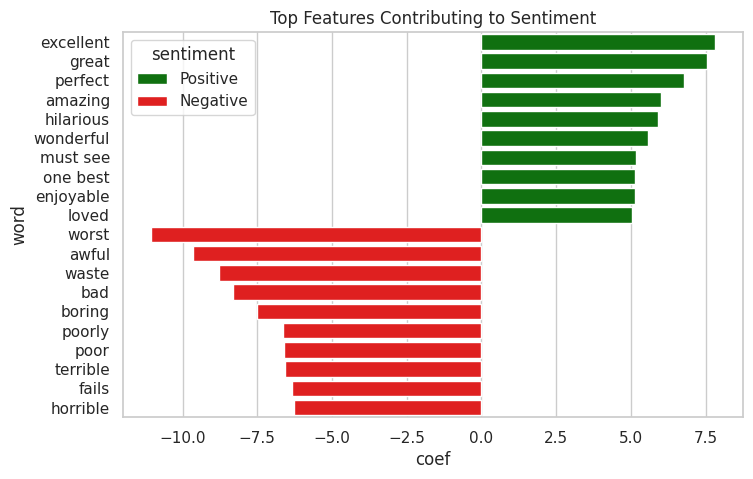

In [ ]:
top_features = pd.DataFrame({
    'word': np.concatenate([feature_names[top_pos_idx][:10], feature_names[top_neg_idx][:10]]),
    'coef': np.concatenate([coefs[top_pos_idx][:10], coefs[top_neg_idx][:10]]),
    'sentiment': ['Positive']*10 + ['Negative']*10
})
plt.figure(figsize=(8,5))
sns.barplot(y='word', x='coef', hue='sentiment', data=top_features, dodge=False, palette=['green','red'])
plt.title('Top Features Contributing to Sentiment')
plt.show()

# Conclusion

- We prepared text, engineered features, trained multiple models, and tuned a logistic regression pipeline.
- The tuned model is saved for deployment.
- Future scope: try transformers (BERT), ensembling, and deeper error analysis (examine misclassified long reviews).
